#**아래의 experiment_number 꼭 입력**

In [1]:
experiment_number = 'ConvNeXt_Baseline'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install timm ptflops

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import scipy.io
import timm
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ptflops import get_model_complexity_info
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
!pip install torchprofile
from torchprofile import profile_macs

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
data_dir = '/content/drive/MyDrive/심층신경망개론/'

In [9]:
setid = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))

train_ids = setid['trnid'][0]
valid_ids = setid['valid'][0]
test_ids = setid['tstid'][0]
image_labels = labels['labels'][0]

In [10]:
class OxfordFlowersDataset(Dataset):
    def __init__(self, image_ids, labels, root_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, 'jpg', f'image_{img_id:05d}.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id - 1] - 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
train_dataset = OxfordFlowersDataset(
    image_ids=train_ids,
    labels=image_labels,
    root_dir=data_dir,
    transform=train_transforms
)

valid_dataset = OxfordFlowersDataset(
    image_ids=valid_ids,
    labels=image_labels,
    root_dir=data_dir,
    transform=val_test_transforms
)

test_dataset = OxfordFlowersDataset(
    image_ids=test_ids,
    labels=image_labels,
    root_dir=data_dir,
    transform=val_test_transforms
)

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [13]:
model = models.convnext_tiny(pretrained=True)

in_features_convnext = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features_convnext, 102)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
dummy_input = torch.randn(1, 3, 299, 299).to(device)
flops = profile_macs(model, dummy_input)
print(f"FLOPs: {flops / 1e9:.4f} GFLOPs")

FLOPs: 7.5181 GFLOPs


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::empty". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::bernoulli_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=0.0015240807648509965, weight_decay=3.432597361947343e-05)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True,
    threshold=1e-4,
    threshold_mode='rel'
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
num_epochs = 20
patience = 3
best_val_loss = float('inf')
trigger_times = 0
unfreeze_epoch = 5

<ipython-input-16-e52125fc2efc>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [17]:
save_dir = f'/content/drive/MyDrive/심층신경망개론/model/'
os.makedirs(save_dir, exist_ok=True)

final_model_path = os.path.join(save_dir, f'{experiment_number}_model.pth')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(num_epochs):
    if epoch == unfreeze_epoch:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
        print(f"Unfrozen base layers at epoch: {epoch+1}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
    for inputs, labels in train_bar:
        inputs, labels  = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_labels_list = []

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
    with torch.no_grad():
        for val_inputs, val_labels in val_bar:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            with autocast():
                val_outputs = model(val_inputs)
                val_loss_batch = criterion(val_outputs, val_labels)

            val_loss += val_loss_batch.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            all_preds.extend(val_predicted.cpu().numpy())
            all_labels_list.extend(val_labels.cpu().numpy())

            val_bar.set_postfix(loss=val_loss_batch.item(), accuracy=100 * val_correct / val_total)

    val_epoch_loss = val_loss / len(valid_dataset)
    val_epoch_acc = 100 * val_correct / val_total

    val_accuracy = accuracy_score(all_labels_list, all_preds)
    val_precision = precision_score(all_labels_list, all_preds, average='macro')
    val_recall = recall_score(all_labels_list, all_preds, average='macro')
    val_f1 = f1_score(all_labels_list, all_preds, average='macro')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%')
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation F1-Score: {val_f1:.4f}\n')

    scheduler.step(val_epoch_loss)

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), final_model_path)
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}\n')
        if trigger_times >= patience:
            print('Early stopping!\n')
            break

print("Training completed.")

Epoch 1/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/20 Training: 100%|██████████| 32/32 [01:22<00:00,  2.59s/it, accuracy=46.3, loss=0.499]


Epoch [1/20], Train Loss: 2.6935, Train Accuracy: 46.27%


Epoch 1/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 Validation: 100%|██████████| 32/32 [01:20<00:00,  2.53s/it, accuracy=83.9, loss=0.234]


Validation Loss: 0.6080, Validation Accuracy: 83.92%
Validation Precision: 0.8711
Validation Recall: 0.8392
Validation F1-Score: 0.8369



Epoch 2/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 2/20 Training: 100%|██████████| 32/32 [01:23<00:00,  2.59s/it, accuracy=95.7, loss=0.115]


Epoch [2/20], Train Loss: 0.1779, Train Accuracy: 95.69%


Epoch 2/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 Validation: 100%|██████████| 32/32 [01:20<00:00,  2.50s/it, accuracy=87.7, loss=0.104]


Validation Loss: 0.4478, Validation Accuracy: 87.75%
Validation Precision: 0.8980
Validation Recall: 0.8775
Validation F1-Score: 0.8768



Epoch 3/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 3/20 Training: 100%|██████████| 32/32 [01:24<00:00,  2.63s/it, accuracy=99, loss=0.0344]


Epoch [3/20], Train Loss: 0.0553, Train Accuracy: 99.02%


Epoch 3/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 Validation: 100%|██████████| 32/32 [01:21<00:00,  2.55s/it, accuracy=89.4, loss=0.123]


Validation Loss: 0.3878, Validation Accuracy: 89.41%
Validation Precision: 0.9043
Validation Recall: 0.8941
Validation F1-Score: 0.8931



Epoch 4/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 4/20 Training: 100%|██████████| 32/32 [01:23<00:00,  2.60s/it, accuracy=99.1, loss=0.0242]


Epoch [4/20], Train Loss: 0.0411, Train Accuracy: 99.12%


Epoch 4/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 Validation: 100%|██████████| 32/32 [01:21<00:00,  2.56s/it, accuracy=89.5, loss=0.189]


Validation Loss: 0.3788, Validation Accuracy: 89.51%
Validation Precision: 0.9085
Validation Recall: 0.8951
Validation F1-Score: 0.8951



Epoch 5/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 5/20 Training: 100%|██████████| 32/32 [01:19<00:00,  2.49s/it, accuracy=99.3, loss=0.026]


Epoch [5/20], Train Loss: 0.0346, Train Accuracy: 99.31%


Epoch 5/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 Validation: 100%|██████████| 32/32 [01:20<00:00,  2.50s/it, accuracy=90.3, loss=0.149]


Validation Loss: 0.3649, Validation Accuracy: 90.29%
Validation Precision: 0.9168
Validation Recall: 0.9029
Validation F1-Score: 0.9039

Unfrozen base layers at epoch: 6


Epoch 6/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 6/20 Training: 100%|██████████| 32/32 [03:27<00:00,  6.50s/it, accuracy=99.9, loss=0.0158]


Epoch [6/20], Train Loss: 0.0106, Train Accuracy: 99.90%


Epoch 6/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 Validation: 100%|██████████| 32/32 [00:59<00:00,  1.86s/it, accuracy=91.7, loss=0.0603]


Validation Loss: 0.3125, Validation Accuracy: 91.67%
Validation Precision: 0.9274
Validation Recall: 0.9167
Validation F1-Score: 0.9174



Epoch 7/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 7/20 Training: 100%|██████████| 32/32 [03:10<00:00,  5.94s/it, accuracy=99.9, loss=0.00119]


Epoch [7/20], Train Loss: 0.0067, Train Accuracy: 99.90%


Epoch 7/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 Validation: 100%|██████████| 32/32 [00:52<00:00,  1.63s/it, accuracy=92.5, loss=0.0623]


Validation Loss: 0.3035, Validation Accuracy: 92.45%
Validation Precision: 0.9332
Validation Recall: 0.9245
Validation F1-Score: 0.9247



Epoch 8/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 8/20 Training: 100%|██████████| 32/32 [03:17<00:00,  6.18s/it, accuracy=99.9, loss=0.000569]


Epoch [8/20], Train Loss: 0.0037, Train Accuracy: 99.90%


Epoch 8/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 Validation: 100%|██████████| 32/32 [00:51<00:00,  1.62s/it, accuracy=92.8, loss=0.0277]


Validation Loss: 0.3006, Validation Accuracy: 92.84%
Validation Precision: 0.9375
Validation Recall: 0.9284
Validation F1-Score: 0.9286



Epoch 9/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 9/20 Training: 100%|██████████| 32/32 [03:25<00:00,  6.42s/it, accuracy=99.9, loss=0.00214]


Epoch [9/20], Train Loss: 0.0026, Train Accuracy: 99.90%


Epoch 9/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 Validation: 100%|██████████| 32/32 [00:55<00:00,  1.74s/it, accuracy=92.6, loss=0.0229]


Validation Loss: 0.3142, Validation Accuracy: 92.65%
Validation Precision: 0.9378
Validation Recall: 0.9265
Validation F1-Score: 0.9262

EarlyStopping counter: 1 out of 3



Epoch 10/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 10/20 Training: 100%|██████████| 32/32 [03:10<00:00,  5.95s/it, accuracy=100, loss=0.00199]


Epoch [10/20], Train Loss: 0.0021, Train Accuracy: 100.00%


Epoch 10/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 Validation: 100%|██████████| 32/32 [00:56<00:00,  1.75s/it, accuracy=92.3, loss=0.0206]


Validation Loss: 0.3114, Validation Accuracy: 92.25%
Validation Precision: 0.9331
Validation Recall: 0.9225
Validation F1-Score: 0.9223

EarlyStopping counter: 2 out of 3



Epoch 11/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 11/20 Training: 100%|██████████| 32/32 [03:22<00:00,  6.32s/it, accuracy=99.9, loss=0.0451]


Epoch [11/20], Train Loss: 0.0023, Train Accuracy: 99.90%


Epoch 11/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 Validation: 100%|██████████| 32/32 [00:57<00:00,  1.81s/it, accuracy=92.2, loss=0.0155]


Validation Loss: 0.2986, Validation Accuracy: 92.16%
Validation Precision: 0.9303
Validation Recall: 0.9216
Validation F1-Score: 0.9211



Epoch 12/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 12/20 Training: 100%|██████████| 32/32 [03:20<00:00,  6.28s/it, accuracy=99.9, loss=0.00433]


Epoch [12/20], Train Loss: 0.0035, Train Accuracy: 99.90%


Epoch 12/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 Validation: 100%|██████████| 32/32 [00:56<00:00,  1.78s/it, accuracy=93.1, loss=0.00611]


Validation Loss: 0.3063, Validation Accuracy: 93.14%
Validation Precision: 0.9403
Validation Recall: 0.9314
Validation F1-Score: 0.9304

EarlyStopping counter: 1 out of 3



Epoch 13/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 13/20 Training: 100%|██████████| 32/32 [03:22<00:00,  6.32s/it, accuracy=100, loss=0.000269]


Epoch [13/20], Train Loss: 0.0019, Train Accuracy: 100.00%


Epoch 13/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 Validation: 100%|██████████| 32/32 [00:48<00:00,  1.53s/it, accuracy=93, loss=0.0051]


Validation Loss: 0.2976, Validation Accuracy: 93.04%
Validation Precision: 0.9382
Validation Recall: 0.9304
Validation F1-Score: 0.9290



Epoch 14/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 14/20 Training: 100%|██████████| 32/32 [03:18<00:00,  6.21s/it, accuracy=100, loss=0.00191]


Epoch [14/20], Train Loss: 0.0023, Train Accuracy: 100.00%


Epoch 14/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 Validation: 100%|██████████| 32/32 [00:54<00:00,  1.72s/it, accuracy=92.9, loss=0.00484]


Validation Loss: 0.3057, Validation Accuracy: 92.94%
Validation Precision: 0.9371
Validation Recall: 0.9294
Validation F1-Score: 0.9280

EarlyStopping counter: 1 out of 3



Epoch 15/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 15/20 Training: 100%|██████████| 32/32 [03:22<00:00,  6.34s/it, accuracy=99.9, loss=0.0178]


Epoch [15/20], Train Loss: 0.0049, Train Accuracy: 99.90%


Epoch 15/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 Validation: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, accuracy=93, loss=0.00377]


Validation Loss: 0.2978, Validation Accuracy: 93.04%
Validation Precision: 0.9368
Validation Recall: 0.9304
Validation F1-Score: 0.9295

EarlyStopping counter: 2 out of 3



Epoch 16/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 16/20 Training: 100%|██████████| 32/32 [03:24<00:00,  6.38s/it, accuracy=100, loss=0.00156]


Epoch [16/20], Train Loss: 0.0011, Train Accuracy: 100.00%


Epoch 16/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 Validation: 100%|██████████| 32/32 [00:54<00:00,  1.71s/it, accuracy=93, loss=0.00363]


Validation Loss: 0.2946, Validation Accuracy: 93.04%
Validation Precision: 0.9366
Validation Recall: 0.9304
Validation F1-Score: 0.9294



Epoch 17/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 17/20 Training: 100%|██████████| 32/32 [03:20<00:00,  6.27s/it, accuracy=100, loss=6.97e-5]


Epoch [17/20], Train Loss: 0.0008, Train Accuracy: 100.00%


Epoch 17/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 Validation: 100%|██████████| 32/32 [00:54<00:00,  1.69s/it, accuracy=93.2, loss=0.00358]


Validation Loss: 0.2883, Validation Accuracy: 93.24%
Validation Precision: 0.9386
Validation Recall: 0.9324
Validation F1-Score: 0.9315



Epoch 18/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 18/20 Training: 100%|██████████| 32/32 [03:20<00:00,  6.28s/it, accuracy=100, loss=0.00038]


Epoch [18/20], Train Loss: 0.0009, Train Accuracy: 100.00%


Epoch 18/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 Validation: 100%|██████████| 32/32 [00:56<00:00,  1.77s/it, accuracy=93.7, loss=0.00367]


Validation Loss: 0.2852, Validation Accuracy: 93.73%
Validation Precision: 0.9431
Validation Recall: 0.9373
Validation F1-Score: 0.9362



Epoch 19/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 19/20 Training: 100%|██████████| 32/32 [03:23<00:00,  6.35s/it, accuracy=100, loss=0.000155]


Epoch [19/20], Train Loss: 0.0007, Train Accuracy: 100.00%


Epoch 19/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 Validation: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it, accuracy=93.5, loss=0.00417]


Validation Loss: 0.2834, Validation Accuracy: 93.53%
Validation Precision: 0.9415
Validation Recall: 0.9353
Validation F1-Score: 0.9346



Epoch 20/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 20/20 Training: 100%|██████████| 32/32 [03:17<00:00,  6.18s/it, accuracy=100, loss=0.000161]


Epoch [20/20], Train Loss: 0.0005, Train Accuracy: 100.00%


Epoch 20/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-17-c577f75159f6>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 Validation: 100%|██████████| 32/32 [00:50<00:00,  1.59s/it, accuracy=93.7, loss=0.00447]


Validation Loss: 0.2807, Validation Accuracy: 93.73%
Validation Precision: 0.9428
Validation Recall: 0.9373
Validation F1-Score: 0.9365

Training completed.


<ipython-input-18-d106ab3010ac>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_model_path))


Loaded final model from /content/drive/MyDrive/심층신경망개론/model/ConvNeXt_model.pth


Testing:   0%|          | 0/193 [00:00<?, ?it/s]<ipython-input-18-d106ab3010ac>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Testing: 100%|██████████| 193/193 [10:20<00:00,  3.22s/it, accuracy=92.01%, loss=0.000689, top5_accuracy=98.26%]


Test Loss: 0.3210, Top-1 Accuracy: 92.01%, Top-5 Accuracy: 98.26%
Test Precision: 0.9109
Test Recall: 0.9250
Test F1-Score: 0.9145


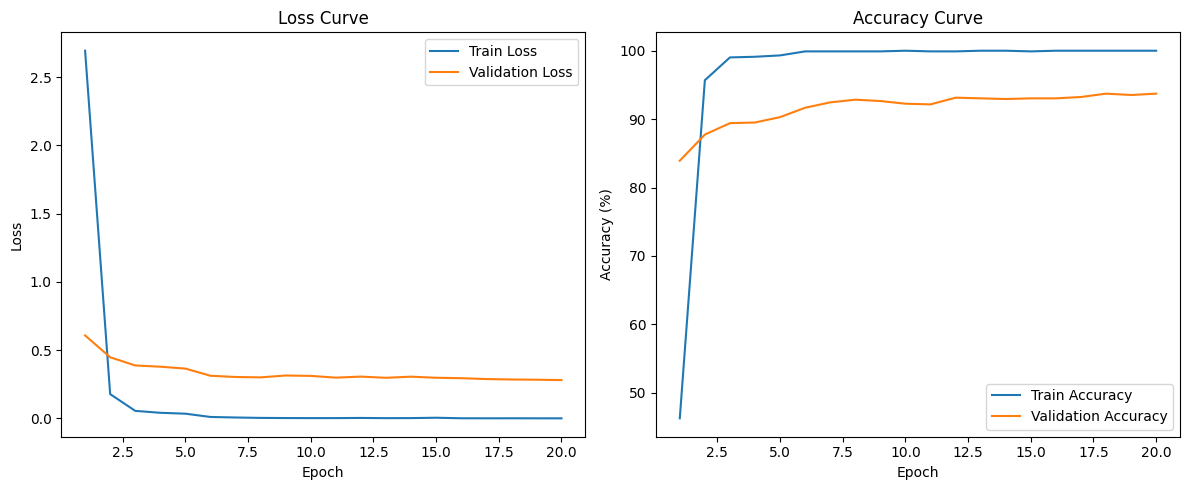

[2.693538125589782, 0.17792328441259908, 0.055275330575657824, 0.04111679657271095, 0.03457561197015, 0.010583208048460531, 0.006686388945444396, 0.0037227258654585218, 0.002634105267112746, 0.002149737034193879, 0.0023251788845906657, 0.0034640855331649527, 0.0018981155102807737, 0.0022750136730096794, 0.004893095821470898, 0.0010929075816153166, 0.0007745467971807218, 0.0009372718858203905, 0.0006738918593185315, 0.000494405713249637]
[46.27450980392157, 95.68627450980392, 99.01960784313725, 99.11764705882354, 99.31372549019608, 99.90196078431373, 99.90196078431373, 99.90196078431373, 99.90196078431373, 100.0, 99.90196078431373, 99.90196078431373, 100.0, 100.0, 99.90196078431373, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.6079589985749301, 0.4478413461762316, 0.3878251279393832, 0.37883291790882745, 0.3649271509226631, 0.312491817363337, 0.3034617961986977, 0.3006127603425115, 0.3142391341501007, 0.3114487400534106, 0.2986496098339558, 0.30628668783123003, 0.2975875808017365, 0.3056585717

In [18]:
from sklearn.metrics import top_k_accuracy_score

try:
    model.load_state_dict(torch.load(final_model_path))
    print(f'Loaded final model from {final_model_path}')
except Exception as e:
    print(f'Error loading the final model: {e}')

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_correct_top5 = 0

test_all_preds = []
test_all_labels = []
test_all_probs = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Testing")

    for test_inputs, test_labels in test_bar:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        with autocast():
            test_outputs = model(test_inputs)
            test_loss_batch = criterion(test_outputs, test_labels)

        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

        top5_probs, top5_predicted = torch.topk(test_outputs, 5, dim=1)
        test_correct_top5 += torch.sum(top5_predicted.eq(test_labels.view(-1, 1).expand_as(top5_predicted))).item()

        test_all_preds.extend(test_predicted.cpu().numpy())
        test_all_labels.extend(test_labels.cpu().numpy())

        test_all_probs.extend(torch.softmax(test_outputs, dim=1).cpu().numpy())

        current_accuracy = 100 * test_correct / test_total
        current_top5_accuracy = 100 * test_correct_top5 / test_total
        test_bar.set_postfix(loss=test_loss_batch.item(),
                             accuracy=f"{current_accuracy:.2f}%",
                             top5_accuracy=f"{current_top5_accuracy:.2f}%")

test_epoch_loss = test_loss / len(test_dataset)
test_epoch_acc = 100 * test_correct / test_total
test_epoch_top5_acc = 100 * test_correct_top5 / test_total

test_accuracy = accuracy_score(test_all_labels, test_all_preds)
test_precision = precision_score(test_all_labels, test_all_preds, average='macro')
test_recall = recall_score(test_all_labels, test_all_preds, average='macro')
test_f1 = f1_score(test_all_labels, test_all_preds, average='macro')

print('Test Loss: {:.4f}, Top-1 Accuracy: {:.2f}%, Top-5 Accuracy: {:.2f}%'.format(
    test_epoch_loss, test_epoch_acc, test_epoch_top5_acc))
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)